In [1]:
import numpy as np
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
import os
import scipy.stats as stats
import json
import pandas as pd
from xraysky.scripts import events_imaging
from fitsutil import *
from bcpsf import *
import glob


/storage/home/ajo5182/.conda/envs/xhcd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def analyze_localization_directory(data_dir,window=10,plot = False ):
    data_dir = Path(data_dir)
    # take the names of all folders within the specified directory
    file_list = [file for file in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]
    
    theta = [None]*len(file_list)
    xMean = [None]*len(file_list)
    yMean =[None]*len(file_list)
    xSigma = [None]*len(file_list)
    ySigma = [None]*len(file_list)
    Amplitude = [None]*len(file_list)
    peakSig = [None]*len(file_list)
    cov = [None]*len(file_list)
    validPeak = [None]*len(file_list)
    pval = [np.nan]*len(file_list) 
    

    for a in range(len(file_list)): 
        #
        #
        # numTerms = len(file_list[a].split('_'))
        #if numTerms == 7:
        #    run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a], hTheta[a] =  file_list[a].split('_')

        #elif numTerms == 6:
        #    run[a], anode[a], detectorMode[a], temp[a], sweep[a], vTheta[a] = file_list[a].split('_')
        #    vTheta[a] = 'NA'
        #    hTheta[a] = 'NA'
        #elif numTerms == 4:
        #    run[a], anode[a], detectorMode[a], temp[a] = file_list[a].split('_') 
        #elif numTerms == 3:
        #    run[a],vTheta[a], hTheta[a] = file_list[a].split('_')
        #
        if os.path.isfile(f"{data_dir}/{file_list[a]}"):
            data_path = Path(f"{data_dir}/{file_list[a]}")
        try:
            d = fits.open(data_path) # open fits file
        
            data = d[0].data # data contents of the fits file
            #shape =  data.shape

            ny, nx = data.shape
            ym, xm = np.mgrid[:ny, :nx]

            w = WCS(d[0].header)

            x,y= w.array_index_to_world_values(ym,xm)
            x = (x+(180+360)) % 360 -180

            peak = np.max(data)
            peak_loc = np.unravel_index(np.argmax(data),data.shape)
            window = 10

            windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
            x_window = x[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
            y_window = y[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

            fitted,covariance_matrix = fit_rotated_2d_gaussian(windowed_data, x_window, y_window, plot_result=plot,iter=file_list[a])
        
            validPeak[a] = True
            xMean[a] = fitted.x_mean.value
            yMean[a] = fitted.y_mean.value
            xSigma[a] = fitted.x_stddev.value
            ySigma[a] = fitted.y_stddev.value
            Amplitude[a] = fitted.amplitude.value
            theta[a] =fitted.theta.value
            cov[a] = covariance_matrix
        except:
            validPeak[a] = "corrupt Fits"
        else:
            validPeak[a] = False  
        ######## Adjust whats in between the ########################################
        imager= events_imaging.BC_Imaging()
        peaks = imager.imager.findpeaks(data) # Index 5 has the significance
        if len(peaks) == 1: 
            peakSig = peaks[5]
        if len(peaks) == 2:
            peakSig = peaks[0]
            peakSig = peakSig[5]
        ###########################################################################
    result = {
        "xCenter" : xMean,
        "yCenter" : yMean,
        "xSigma" : xSigma,
        "ySigma" : ySigma,
        "peak" : Amplitude,
        "peakSig" : peakSig,
        "theta" : theta,
        'covMatrix' : cov
    }

    result = pd.DataFrame(result)
    return result

In [ ]:
d = fits.open("/home/laurel/astro/testing/test_reconstruct.fits.gz")


In [ ]:
eventlistPath = Path(r"/scratch/ajo5182/psfSamples/image_reconstruction/BC056_Ti_EDS_243K_EA_R01_samp1.fits.gz")

In [ ]:
d = fits.open(eventlistPath)

In [ ]:
imager= events_imaging.BC_Imaging()
peaks = imager.imager.findpeaks(d[0].data)

In [ ]:
im_hdu = imager.evtlist2image(
        "/scratch/ajo5182/psfSamples/BC057_Ti_FF_233_HORI_10_0_samp2.fits.gz",
        "/scratch/ajo5182/test.fits.gz"
)
imager.plotSource(im_hdu)

In [ ]:
f = [None]*len(peaks)
for a in range(np.size(peaks)):
    f[a] = peaks[a][5]
max(f)

r = max([None])

In [ ]:
a = range(3)

In [ ]:
out = analyze_localization(d,plot=True)


In [ ]:
from scipy.optimize import curve_fit

def circular_gaussian_2d(x, y, amplitude, x_mean, y_mean, sigma, offset):
    """
    2D Circular Gaussian function.
    sigma represents the standard deviation in both x and y directions.
    """
    exponent = -((x - x_mean)**2 + (y - y_mean)**2) / (2 * sigma**2)
    return offset + amplitude * np.exp(exponent)


In [ ]:
# Create x and y coordinates
x_data = np.linspace(0, 100, 101)
y_data = np.linspace(0, 100, 101)
x_mesh, y_mesh = np.meshgrid(x_data, y_data)

# Create synthetic data with some noise
true_amplitude = 10.0
true_x_mean = 50.0
true_y_mean = 50.0
true_sigma = 10.0
true_offset = 5.0

synthetic_data = circular_gaussian_2d(x_mesh, y_mesh, true_amplitude, true_x_mean, true_y_mean, true_sigma, true_offset)
synthetic_data_noisy = synthetic_data + 5.0 * np.random.normal(size=synthetic_data.shape)

In [ ]:
# Flatten the 2D data for curve_fit
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
data_flat = synthetic_data_noisy.ravel()

In [ ]:
plt.imshow(synthetic_data_noisy)

In [ ]:
# Initial guess for the parameters (amplitude, x_mean, y_mean, sigma, offset)
initial_guess = [8.0, 55.0, 45.0, 8.0, 3.0]

# Perform the curve fitting
popt, pcov = curve_fit(circular_gaussian_2d, x_flat, y_flat, data_flat)

# Extract the fitted parameters
fitted_amplitude, fitted_x_mean, fitted_y_mean, fitted_sigma, fitted_offset = popt

In [18]:
def fit_rotated_2d_gaussian(data, x=None, y=None, plot_result=False,iter = None):
    """
    Fit a rotated 2D Gaussian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    # Initial guess for model
    gauss_init = models.Gaussian2D(amplitude_init, x_mean_init,
                                   y_mean_init, 0.089, 0.069, 0, {"theta":True})

    # Fitting with Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gauss_init, x, y, data)
    covariance_matrix = fitter.fit_info['param_cov']
    if fitted_model.x_fwhm > 1 or fitted_model.y_fwhm >1 :
        print(iter)

    if plot_result:
        fit_data = fitted_model(x, y)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].imshow(fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Gaussian")
        plt.tight_layout()
        plt.show()

    return fitted_model,covariance_matrix

CHAT GPT code for tieuibng x and y together

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Create synthetic data
y, x = np.mgrid[-5:5:100j, -5:5:100j]
data = models.Gaussian2D(amplitude=3, x_mean=0, y_mean=0,
                         x_stddev=1, y_stddev=1)(x, y) + np.random.normal(0, 0.1, x.shape)

# Define a tie function: y_stddev is tied to x_stddev
def tie_stddev(model):
    return model.x_stddev

# Create initial model with tied standard deviations
g_init = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0,
                           x_stddev=1, y_stddev=1,
                           tied={'y_stddev': tie_stddev})

# Fit the model
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, x, y, data)

# Show fitted parameters
print(g_fit)

# Plot data and fit
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Data')
plt.imshow(data, origin='lower', interpolation='none')

plt.subplot(1, 2, 2)
plt.title('Fitted Gaussian')
plt.imshow(g_fit(x, y), origin='lower', interpolation='none')

plt.tight_layout()
plt.show()


Code for circular gaussian

Fitted amplitude: 4.938008320851975
Fitted x_mean: 0.006028374439140292
Fitted y_mean: 0.013484050511667886
Fitted stddev (circular): 1.5043810593829392
[[ 3.23526063e-01 -2.47042959e-07  5.64554443e-08 -6.57325805e-02]
 [-2.47042959e-07  4.00325244e-02  3.36316407e-19  1.65905235e-07]
 [ 5.64554443e-08  3.36316407e-19  4.00325268e-02  4.42429918e-17]
 [-6.57325805e-02  1.65905235e-07  4.42429918e-17  4.00532287e-02]]


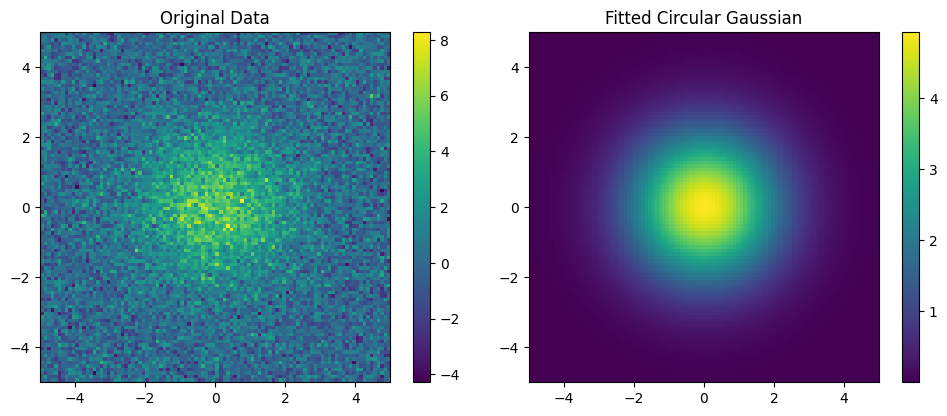

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Create synthetic data for a circular Gaussian
y, x = np.mgrid[-5:5:100j, -5:5:100j]
true_stddev = 1.5
data = models.Gaussian2D(amplitude=5, x_mean=0, y_mean=0,
                         x_stddev=true_stddev, y_stddev=true_stddev, theta=0)(x, y)
data += np.random.normal(0, 1.2, x.shape)  # Add some noise

# Define a tie function to enforce circular symmetry: y_stddev = x_stddev
def tie_stddev(model):
    return model.x_stddev

# Set up the initial model with tied stddevs and fixed theta = 0
g_init = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0,
                           x_stddev=1, y_stddev=1, theta=0,
                           tied={'y_stddev': tie_stddev})
g_init.theta.fixed = True  # Fix theta to 0 to prevent rotation

# Fit the model to the data
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, x, y, data)


# Print fitted parameters
print(f"Fitted amplitude: {g_fit.amplitude.value}")
print(f"Fitted x_mean: {g_fit.x_mean.value}")
print(f"Fitted y_mean: {g_fit.y_mean.value}")
print(f"Fitted stddev (circular): {g_fit.x_stddev.value}")
print(fitter.fit_info['param_cov'])

# Plot the original data and the fitted model
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Original Data')
plt.imshow(data, origin='lower', interpolation='none', extent=[-5, 5, -5, 5])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Fitted Circular Gaussian')
plt.imshow(g_fit(x, y), origin='lower', interpolation='none', extent=[-5, 5, -5, 5])
plt.colorbar()

plt.tight_layout()
plt.show()


In [11]:
def fit_circular_gaussian(data, x=None, y=None, plot_result=False,iter = None):
    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]
    
    def tie_stddev(model):
        return model.x_stddev
    gauss_init = models.Gaussian2D(amplitude=amplitude_init, x_mean=x_mean_init, y_mean=y_mean_init,
                           x_stddev=0.069, y_stddev=0.069, theta=0,
                           tied={'y_stddev': tie_stddev})
    gauss_init.theta.fixed = True  # Fix theta to 0 to prevent rotation

    # Fit the model to the data
    fitter = fitting.LevMarLSQFitter()
    g_fit = fitter(gauss_init, x, y, data)
    fitted_model = fitter(gauss_init, x, y, data)
    covariance_matrix = fitter.fit_info['param_cov']
    
    if plot_result == True:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.title('Original Data')
        plt.imshow(data, origin='lower', interpolation='none', extent=[-5, 5, -5, 5])   
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('Fitted Circular Gaussian')
        plt.imshow(g_fit(x, y), origin='lower', interpolation='none', extent=[-5, 5, -5, 5])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
    
    return fitted_model,covariance_matrix

    

    

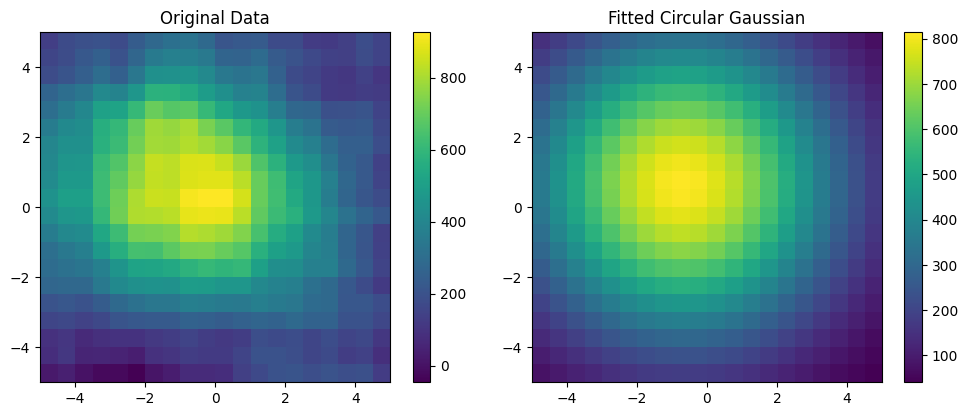

In [21]:
eventlistin = '/scratch/ajo5182/psfSamples/image_reconstruction/BC057_Ti_FF_233_HORI_10_0_samp2.fits.gz'

eventlistin = fits.open(Path(eventlistin))
data = eventlistin[0].data

ny, nx = data.shape
ym, xm = np.mgrid[:ny, :nx]

w = WCS(eventlistin[0].header)

x,y= w.array_index_to_world_values(ym,xm)
x = (x+(180+360)) % 360 -180

peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 10

windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
x_window = x[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]
y_window = y[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

fitted,covariance_matrix = fit_circular_gaussian(windowed_data, x_window, y_window, plot_result=True)

aError, xMean_error, yMean_error, Sigma_error = np.sqrt(np.diag(covariance_matrix))

validPeak = True
xMean = fitted.x_mean.value
yMean = fitted.y_mean.value
xSigma = fitted.x_stddev.value
ySigma = fitted.y_stddev.value
Amplitude = fitted.amplitude.value
theta =fitted.theta.value
cov = covariance_matrix
    
imager= events_imaging.BC_Imaging()
peaks = imager.imager.findpeaks(data,minsigma=5.0) # Index 5 has the significance
try:
    f = [None]*len(peaks)
    for a in range(len(peaks)):
        f[a] = peaks[a][5]
    peakSig = max(f)
except:
    print("issue with finding peaks")
    peakSig = None

result = {
        "xCenter" : xMean,
        "yCenter" : yMean,
        "xSigma" : xSigma,
        "ySigma" : ySigma,
        "peak" : Amplitude,
        "peakSig" : peakSig,
        "theta" : theta
    }

    #result = pd.DataFrame(result)



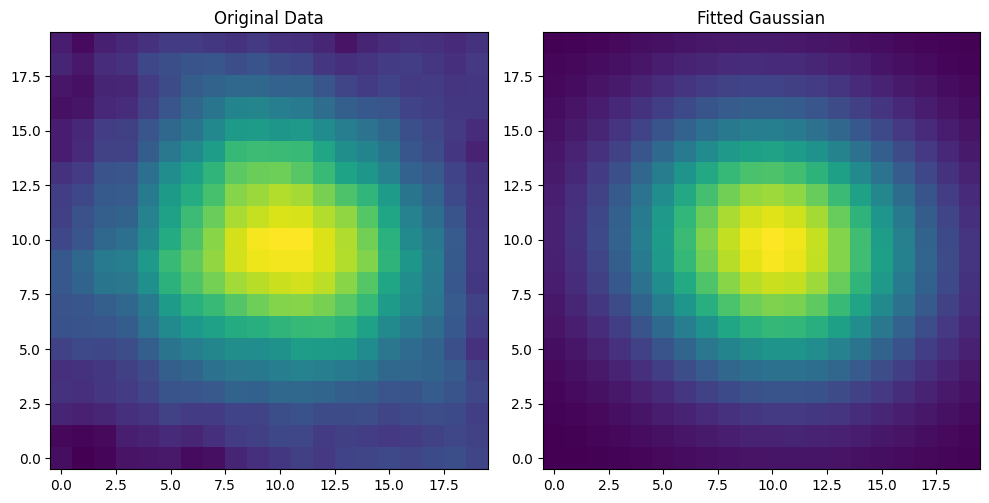

In [4]:
fitted,covariance_matrix = fit_rotated_2d_gaussian(windowed_data, x_window, y_window, plot_result=True)
